In [1]:
import pandas as pd
import osmnx as ox
import config
import peartree as pt
import partridge as ptg
import networkx as nx

In [2]:
feed = ptg.load_feed(f"{config.testing_data_path}/"
                     f"google_transit_locallink.zip")

In [ ]:
# feed = pt.get_representative_feed(f"{config.testing_data_path}/"
#                                   f"google_transit_locallink.zip")
# len(feed.stops)

In [3]:
# filter the feed so to only include bus stops with a latitude greater
# than the minimum latitude value from the population data
# population_data = pd.read_csv(config.population_csv)
# min_lat = population_data.lat.min()
# min_lat

54.4688255

In [4]:
# filtered_stops = feed.stops[feed.stops.stop_lat >= min_lat]
# len(filtered_stops)

164

In [5]:
# find stops with "Derry" in their name.
# filtered_stops[filtered_stops["stop_name"].str.contains("Derry")]

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road),55.004476,-7.321782
656,853000095,Molloys Supermarket Derrybeg,55.078139,-8.289987
784,gen:31400:890:0:1,"Derry, Water Street",54.996069,-7.317329
875,gen:57402:8160:0:1,"Derrycassan Cottages, Simons",55.203874,-7.849413
876,gen:57402:8161:0:1,"Derrycassan, Grotto",55.210575,-7.856003


In [6]:
# remove the Derry stops
# ids_to_exclude = ["7000B158241", "gen:31400:890:0:1"]
# filtered_stops = filtered_stops[~filtered_stops["stop_id"].isin(ids_to_exclude)]

In [28]:
# get donegal records from stop_times to find the path followed
# filtered_stop_times = feed.stop_times[
#     feed.stop_times.stop_id.isin(
#         filtered_stops["stop_id"])]

In [29]:
# get donegal routes, agency_id="LLDL"
filtered_routes = feed.routes[feed.routes.agency_id == "LLDL"]

In [30]:
# route ids
donegal_routes = filtered_routes.route_id.to_list()

In [43]:
# ###################
# a = filtered_stop_times["trip_id"].str.contains("49-568-y11-1")
# b = a[a.values == True]

In [44]:
# use the route ids to find matches in filtered stop times,
# add route_id column and find unique stop time records
stop_times = feed.stop_times
for route in donegal_routes:
    stop_times.loc[
        stop_times["trip_id"].str.contains(route), "route_id"] = route

In [51]:
# keep only route, stop and sequence columns and drop duplicate rows
routes = stop_times[["route_id", "stop_id", "stop_sequence"]]
# stop_times[stop_times.route_id == "49-568-y11-1"]

In [ ]:
# find stops with "Derry" in their name.
feed.stops[feed.stops["stop_name"].str.contains("Derry")]

In [52]:
# remove the Derry stops from route times
ids_to_exclude = ["7000B158241", "gen:31400:890:0:1"]
routes = routes[~stop_times["stop_id"].isin(ids_to_exclude)]
len(routes)

10415

In [53]:
routes = routes.drop_duplicates()
len(routes)

1869

In [54]:
route_dict = {route: routes.loc[routes["route_id"] == route] for route in donegal_routes}










In [ ]:
######################################
feed.set("stops.txt", filtered_stops)
len(feed.stops)

In [9]:
start = 1
end = 86400
%time G = pt.load_feed_as_graph(feed, start, end)

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/peartree/parallel.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  direction_subset = stop_times_by_stop[constraint_2]


CPU times: user 5.79 s, sys: 11.5 ms, total: 5.8 s
Wall time: 5.84 s


/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3703dd9610>)

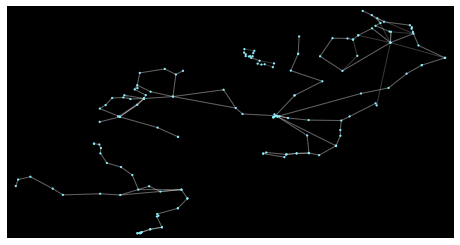

In [10]:
import matplotlib as mpl

ox.plot_graph(G,
              show=False,
              close=False,
              node_color='#8aedfc',
              node_size=5,
              edge_color='#e2dede',
              edge_alpha=0.25,
              bgcolor='black')

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# We need a coverage area, based on the points from the
# New Orleans GTFS data, which we can pull from the peartree
# network graph by utilizing coordinate values and extracting
# a convex hull from the point cloud
boundary = gpd.GeoSeries(
    [Point(n['x'], n['y']) for i, n in G.nodes(data=True)]
    ).unary_union.convex_hull

# Visually inspect
boundary

In [ ]:
%time
G_all_routes = ox.load_graphml(filepath=f"{config.rp_graphml_path}/all_routes.graphml")
# Gdrive = ox.graph_from_polygon(boundary, network_type='drive')

In [ ]:
ox.plot_graph(G_all_routes)

In [ ]:
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=G_all_routes)

In [ ]:
# nodes, edges = ox.graph_to_gdfs(G2)
ox.plot_graph(G2)

In [ ]:
n = nx.get_node_attributes(G2, "modes")

In [ ]:
nodes = G2.nodes(data=True)
edges = G2.edges(data=True)

In [ ]:
nodes['OJ097_gen:57402:8224:0:1']

In [32]:
###########################
# load population dataset, need to check min value
# for latitude columns
population_data = pd.read_csv(config.population_csv)
min_lat = population_data["lat"].min()

In [4]:
# load locallinks stop data.
# filter to only include stops within range of latitude/longitude
locallink_stops = pd.read_csv(f"{config.locallink_data_path}/stops.txt")
locallink_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road) 1,55.004476,-7.321782
1,821000001,Green Lane 1,52.841907,-6.916965
2,821000002,Green Lane 2,52.841728,-6.916984
3,8210B3355701,"Carlow, Carlow Coach Park ->SW2",52.833629,-6.926847
4,8210B351711,Lucy Nolan's 1,52.740188,-6.770400


In [5]:
donegal_stops = locallink_stops[(locallink_stops["stop_lat"] >= min_lat)]
pd.set_option('display.max_rows', 15)
donegal_stops
# there are unexpected stops returned. e.g Derry, Magee Campus
# cross check stops with stop times data

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road) 1,55.004476,-7.321782
630,853000002,Portsalon 2,55.205555,-7.636540
631,853000004,"Arryheernabin, Fanad Lighthouse 1",55.276113,-7.632418
632,853000007,Falcarragh 1,55.136505,-8.104273
633,853000009,Fintown 1,54.868210,-8.124345
...,...,...,...,...
868,gen:57402:8177:0:1,"Buncrana, Buncrana 1",55.136192,-7.456586
869,gen:57402:8178:0:1,"Tir Na Sligo, Tiernasligo National School 1",55.269323,-7.497034
870,gen:57402:8179:0:1,"Straid (Donegal), Waterfall 1",55.267925,-7.436002
871,gen:57402:8224:0:1,"Bridge End, 19th Hole Bar 1",55.044388,-7.381098


In [6]:
len(donegal_stops)

162

In [7]:
# save to csv for manual removal of stops not in Donegal
donegal_stops.to_csv(f"{config.locallink_data_path}/donegal_stops_for_manual_review.csv")

In [9]:
# removed derry stops
updated_donegal_stops = pd.read_csv(f"{config.locallink_data_path}/donegal_stops_updated.csv")
len(updated_donegal_stops)
# ready to find closest nodes on road network graph to add LL labels

160